### Question 1

In [1]:
import numpy as np
from qat.lang.AQASM import Program, H,  AbstractGate, QRoutine, CNOT
from scipy import linalg # for linalg.expm, the matrix exponential.
from qat.qpus import get_default_qpu # numerical simulator for small quantum circuits.
qpu = get_default_qpu()
# PUT YOUR IMPLEMENTATION HERE. Take inspiration from the "minimal notebook" that was sent to you. 



prog = Program() # The object we use to "accumulate" the gates when building the circuits

q = prog.qalloc(2) # Allocation of a register of 2 qubits called q. It is addressable with [.] like an array.
                   # We will only work with one register in this session, but defining several is possible !

prog.apply(H, q[0]) # The first instruction of the program is the application of an Hadamard gate onto q[0]

def matrix(theta):
    X = np.array([[0,1],[1,0]])
    return linalg.expm(-1j * theta * X)

ham_x = AbstractGate("ham_X", [float], arity=1, matrix_generator=matrix) # definition of a custom parametrized gate

prog.apply(ham_x(0.3).ctrl(), q) # The third instuction is the application of our custom gate onto q[0]


circ = prog.to_circ() # The program is exported into a circuit.  



# displaying the circuit:
%qatdisplay --svg circ



### Hamiltonian data

The purpose of the TP is to reproduce, using numerical simulation, Figure 3.(a) of https://arxiv.org/abs/1512.06860.

On this figure, the ground state energy of a dihydrogen molecule is plotted against the distance $R$ separating the hydrogen atoms. It allows to predict the **equilibrium bond length** of the molecule.

*Note*: In more complicated settings with larger molecules, energy may be plotted against various distances and angles, forming an *energy landscape* that proves useful in predicting chemical reaction mechanisms, rates, etc.

The cell below imports the data of Table I of https://arxiv.org/abs/1512.06860.

In [2]:
#importing Hamiltonian data.
import json 

with open('hamiltonian_data.json','r') as f:
    ham_data = json.load(f)
    
for coeffs in ham_data:
    print(coeffs)

FileNotFoundError: [Errno 2] No such file or directory: 'hamiltonian_data.json'

### Question 2:
Following the QRoutine minimal example below, implement QRoutines for each of the Hamiltonian evolutions we need.


#### QRoutine: minimal example

In [362]:
from qat.lang.AQASM import RZ
def f(dt):
    
    routine = QRoutine()
    
    routine.apply(RZ(dt), 0)            # like a Program, except that gates are applied to "wires" 
    routine.apply(CNOT, 0, 1)      # numbered from 0 to the max number that has been seen.
    routine.apply(H, 0)
    
    return routine

#Pasting it into a circuit

prog = Program()

q = prog.qalloc(4)

a = f(0.1)

prog.apply(a, q[:2])
prog.apply(f(0.2), q[1:3])
prog.apply(f(0.3).ctrl(), q[1:]) #Controlled version

circ = prog.to_circ()

%qatdisplay --svg circ        

#### Hamiltonian evolutions to implement

In [363]:
from qat.lang.AQASM import CNOT, RZ, RX, RY, S, I

def u_11_matrix(dt):
    # needed for accurate energy values.
    return np.diag([np.exp(-1j*dt),np.exp(-1j*dt),np.exp(-1j*dt),np.exp(-1j*dt)])

U_II = AbstractGate("II",[float],arity=2,matrix_generator=u_11_matrix)
    
def U_II_bis(dt):
    ii_r = QRoutine()
    ii_r.apply(U_II(dt),0,1)
    return ii_r

def U_ZZ(dt):
    
    zz_r = QRoutine()
    zz_r.apply(CNOT, 0, 1)
    zz_r.apply(RZ(2*dt), 1) # difference of convention between implemented version and what we need.
    zz_r.apply(CNOT, 0, 1)
    return zz_r

#Implement, as above, all the other hamiltonian simulations here.
def U_ZI(dt):
    zi_r =  QRoutine()
    zi_r.apply(RZ(2*dt), 0)
    zi_r.apply(I, 1)
    return zi_r

def U_IZ(dt):
    iz_r =  QRoutine()
    iz_r.apply(RZ(2*dt), 1)
    iz_r.apply(I, 0)
    return iz_r

def U_XX(dt):
    xx_r = QRoutine()
    xx_r.apply(CNOT, 0, 1)
    xx_r.apply(RX(2*dt), 0) # difference of convention between implemented version and what we need.
    xx_r.apply(CNOT, 0, 1)
    return xx_r

def U_YY(dt): 
    yy_r = QRoutine()
    yy_r.apply(S.dag(),1)
    yy_r.apply(CNOT, 0, 1)
    yy_r.apply(RY(2*dt), 0) # difference of convention between implemented version and what we need.
    yy_r.apply(CNOT, 0, 1)
    yy_r.apply(S,1)
    return yy_r    
check = True # turn true to plot and see what you do



if check:
    prog = Program()
    q = prog.qalloc(2)
    prog.apply(U_YY(3.), q)
    circ = prog.to_circ()

    #uncomment following line to plot circuit
    %qatdisplay --svg circ


### Question 3:
Implement a function returning a Qroutine implementing a Trotterized evolution generated by our Hamiltonian.

In [364]:
def trotter_ham_simulation(ham_coeffs, dt, p, shift):
    """
    Args:
        - ham_coeffs: a dictionary from the list of dictionaries loaded from hamiltonian_data.json.
        Therefore its keys are "I_coeff", "Z0_coeff", etc.
        - dt: a float, corresponding to the interval of time whose value we will define later.
        - p: the "Trotter number": the integer controlling the degree of approximation
        - shift: an energy shift to the Hamiltonian to make sure that the value of the ground state energy
        is positive. It consists in adding +shift*I to the Hamiltonian.
    """
    g0=ham_coeffs["I_coeff"]
    g1=ham_coeffs["Z0_coeff"]
    g2=ham_coeffs["Z1_coeff"]
    g3=ham_coeffs["Z0Z1_coeff"]
    g4=ham_coeffs["Y0Y1_coeff"]
    g5=ham_coeffs["X0X1_coeff"]
    qroutine = QRoutine()
    L_apply=[(U_II((g0+shift)*dt/p)),(U_ZI(g1*dt/p)),(U_IZ(g2*dt/p)),(U_ZZ(g3*dt/p)),(U_YY(g4*dt/p)),(U_XX(g5*dt/p))]
    L_routine=L_apply*p
    for routine in L_routine:
        qroutine.apply(routine,q)
    # Hint: gates are regular python objects, they can be put in a list.
            
    return qroutine



In [365]:
# IDEAL HAMILTONIAN SIMULATION: we will use it to compare to the Trotterized version.
def perfect_ham_simulation(ham_coeffs, dt, shift):

    I = np.eye(4)
    Z0 = np.diag([1,1,-1,-1])
    Z1 = np.diag([1,-1,1,-1])
    Z0Z1 = np.diag([1,-1,-1,1])
    X0X1= np.fliplr(np.eye(4))
    Y0Y1 = np.fliplr(np.diag([-1, 1, 1, -1]))

    H = (ham_coeffs['I_coeff']+shift) * I
    H += ham_coeffs['Z0_coeff'] * Z0
    H += ham_coeffs['Z1_coeff'] * Z1
    H += ham_coeffs['Z0Z1_coeff'] * Z0Z1
    H += ham_coeffs['X0X1_coeff'] * X0X1
    H += ham_coeffs['Y0Y1_coeff'] * Y0Y1

    U = linalg.expm(-1j * dt * H)

    def matrix():
        return U

    U_gate = AbstractGate("U", [], arity=2,
                     matrix_generator=matrix)

    qroutine = QRoutine()

    qroutine.apply(U_gate(), 0, 1)

    return qroutine

### Question 4: Implement iterative phase estimation
As a function taking as input an Hamiltonian and execution parameters, and returning a phase.

In [366]:
from qat.lang.AQASM import X

E_max = 3
E_min = -2
    
dt = (2 * np.pi) / float(E_max)


def phase(coeffs, trotterization=False, trotter_number=4, shift=-E_min, nBits = 10):
    """
    Given Hamiltonian coefficients, compute phi, s.t U|\psi\rangle = e^{-2i\pi\phi}|\psi\rangle
    
    Args:
        - coeffs: a dictionary of coefficients as extracted from the list of dictionaries loaded
        from hamiltonian_data.json
        - trotterization: Boolean flag specifying whether to use the Trotterized evolution or the
        ideal "cheat mode" which exponentiates the Hamiltonian.
        - trotter_number: the "p" controlling the degree of approximation of the Trotterization.
        - shift: the energy shift that we use to make sure that the phase we compute is 0 < phi < 1
        - nBits: The number of precision bits we compute.
        
    Returns:
        - phi, a real number that should fall between 0 and 1.
    """

    b=np.zeros((nBits+1))
    for k in range(nBits, 0, -1): 
        
        # CIRCUIT CREATION
        # Put your implementation here. Paste here the QRoutines 
        phi=0
        for l in range(k+1,nBits):
            phi+=2*np.pi*b[l]/(2**(l-k+1))

        U = trotter_ham_simulation(coeffs, dt*2**(k-1), trotter_number, shift) #U = exp -iHdt

        prog = Program()
        q = prog.qalloc(3)
        prog.apply(X,q[1])
        prog.apply(H,q[0])

        if trotterization:
            prog.apply(U.ctrl(),q)
        else : 
            prog.apply(perfect_ham_simulation(coeffs,dt*2**(k-1),shift).ctrl(),q)
        prog.apply(RZ(phi), q[0])
        prog.apply(H,q[0])


        # CIRCUIT SIMULATION

        job = prog.to_circ().to_job(qubits=[0])
        result = qpu.submit(job)

        # SELECTION OF MOST LIKELY RESULT 
        # Put your implementation here
        
        max_state = result[np.argmax([sample.probability for sample in result])].state.int
        
        b[k] = max_state
           
    # recompute phi
    phi=0
    for k in range(1,nBits+1):
        phi += b[k]*2**(-k) 
    return phi


### Question 5: Plot dissociation curves
Call the function you defined above to compute phases for each values of R. Convert them back to energies, and plot the result for two different Trotter number values: 4 and 10. Both should be wiggly approximations to the ideal curve, but 10 should be closer to it.

In [367]:
vals_perfect = []
vals_trotter_4 = []
vals_trotter_10 = []
Rs = []

shift = -E_min

for coeffs in ham_data:
    phi_perfect = phase(coeffs)
    phi_trotter_4 = phase(coeffs, trotterization=True, trotter_number=4)
    phi_trotter_10 = phase(coeffs, trotterization=True, trotter_number=10)

    # CONVERT PHASES BACK TO ENERGY
    
    print("R", coeffs['R'])
    Rs.append(coeffs['R'])
    
    E=2*np.pi*phi_perfect/dt+E_min
    E_trotter_4=2*np.pi*phi_trotter_4/dt+E_min
    E_trotter_10=2*np.pi*phi_trotter_10/dt+E_min

    vals_perfect.append(E)
    vals_trotter_4.append(E_trotter_4)
    vals_trotter_10.append(E_trotter_10)


R 0.2
R 0.25
R 0.3
R 0.35
R 0.4
R 0.45
R 0.5
R 0.55
R 0.6
R 0.65
R 0.7
R 0.75
R 0.8
R 0.85
R 0.9
R 0.95
R 1.0
R 1.05
R 1.1
R 1.15
R 1.2
R 1.25
R 1.3
R 1.35
R 1.4
R 1.45
R 1.5
R 1.55
R 1.6
R 1.65
R 1.7
R 1.75
R 1.8
R 1.85
R 1.9
R 1.95
R 2.0
R 2.05
R 2.1
R 2.15
R 2.2
R 2.25
R 2.3
R 2.35
R 2.4
R 2.45
R 2.5
R 2.55
R 2.6
R 2.65
R 2.7
R 2.75
R 2.8
R 2.85


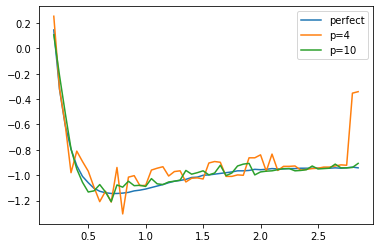

In [368]:
import matplotlib.pylab as plt

plt.plot(Rs, vals_perfect, label="perfect")
plt.plot(Rs, vals_trotter_4, label="p=4")
plt.plot(Rs, vals_trotter_10, label="p=10")
plt.legend()
